# Chuẩn bị


1. Tải Stockfish từ trang chính thức: https://stockfishchess.org/download/

2. Sau khi tải về, đổi tên file `.exe` thành `stockfish`

3. Di chuyển file này vào thư mục: `chess-bot/.venv/bin/`

4. Tải dataset từ https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/input

5. Di chuyển file này vào thư mục chess-bot

## Import thư viện cần thiết

In [ ]:
from stockfish import Stockfish
import numpy as np
import matplotlib.pyplot as plt
import chess
import chess.svg
from typing import List
import pandas as pd
from IPython.display import display, SVG, HTML
import math
from evaluation.evaluation import Evaluation
from evaluation.piece_square_table import PieceSquareTable


## Config đường dẫn

In [ ]:
stockfish_path = ".venv/bin/stockfish"
# stockfish_path = ".venv/Scripts/stockfish.exe"

## Stockfish Engine

In [ ]:
stockfish = Stockfish(stockfish_path)
stockfish.set_skill_level(20)
stockfish.set_depth(20)

In [ ]:
def get_stockfish_score(fen: str) -> float:
    stockfish.set_fen_position(fen)
    score = stockfish.get_evaluation()
    return score["value"] if score["type"] == "cp" else (1000 if score["value"] > 0 else -1000)

## Lấy tập dữ liệu

In [5]:
df = pd.read_csv('chessData.csv')
df.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [6]:
test_fens = df.sample(n=15000, random_state=10)['FEN'].to_list()
stockfish_scores = (
    df.sample(n=1000, random_state=10)['Evaluation']
    .astype(str)
    .str.replace("+", "", regex=False)  # Remove "+"
    .str.extract(r'([-]?\d+)')[0]       # Extract numbers (returns DataFrame, select column 0)
    .astype(float)
    .fillna(0)
    .astype(int)
    .tolist()  # Convert to Python list
)

print(stockfish_scores)
print(sum(stockfish_scores))

[-459, 28, -50, 695, 130, 41, 0, -865, -89, -329, -66, -374, 103, 119, 13, 539, 0, 68, 393, -223, 0, 129, 0, 81, -202, 762, 146, -95, 0, 201, -117, -174, 62, 103, -392, 0, 13, -175, 202, -42, -130, 276, 253, -14, -8, 0, 663, 192, 64, -13, 96, 0, -68, 0, 3, -442, 277, -2, -206, 157, -35, -889, -68, -164, 0, -37, 221, -104, -10, -92, 153, -130, 56, 123, 373, 92, -1039, -5997, 175, -389, 80, 119, 414, -235, 38, -343, -22, 210, -24, 109, -939, -13, 13, -16, 114, -112, -56, -49, -82, -116, 31, 68, 636, 34, -312, -1317, 173, -2, -102, 187, 252, 519, -53, -1, 699, 0, 0, 234, 683, 5305, 3, 494, -100, -3, 17, 52, -27, 4, 86, 857, 169, 49, 88, -13, -1246, -49, 84, -138, 101, 86, -185, 97, -106, -40, 0, -5911, -95, 323, -58, -675, 772, 608, 200, 15, 13, 193, -169, 162, 320, -141, -573, 240, -340, 600, 109, 584, 0, 0, 7224, 114, -46, 15, 333, 307, 428, 376, -1, 314, 0, 105, 1557, 53, 81, -80, 681, 204, 841, -79, 162, -1117, 82, 96, -2293, 898, 972, -139, 5364, -779, 285, 56, 804, 221, -20, 211, 45

## Visualization

In [7]:
def showBoard(fens, boards_per_row=5):
    total_boards = len(fens)
    rows = math.ceil(total_boards / boards_per_row)
    
    for row in range(rows):
        boards_in_row = []
        for col in range(boards_per_row):
            idx = row * boards_per_row + col
            if idx < total_boards:
                board = chess.Board(fens[idx])
                svg = chess.svg.board(board, size=200)  # Giảm size nếu cần
                boards_in_row.append(SVG(svg)._repr_svg_())  # Lấy chuỗi SVG
        
        # Tạo HTML với flexbox để xếp hàng ngang
        html = f"""
        <div style="display: flex; flex-wrap: nowrap; gap: 10px; margin: 10px 0;">
            {''.join(boards_in_row)}
        </div>
        """
        display(HTML(html))

In [8]:
showBoard(df.sample(n=50, random_state=42)['FEN'].to_list())

# 1. Initialization

In [ ]:
import numpy as np

def initialize_population(size: int):
    """
    Initialize a population with chess-specific value ranges.
    
    - The first 5 parameters (evaluation weights) are floating-point numbers.
    - The remaining parameters (piece values, penalties, multipliers) are integers.

    Args:
        size (int): Number of individuals in the population.

    Returns:
        np.ndarray: Population matrix (size, num_params) with meaningful bounds.
    """

    origin_array = PieceSquareTable.tables_to_array() + Evaluation.to_array()
    # Define bounds for each gene type
    bounds = []
    for value in origin_array:
        lower_bound = min(int(value * 0.8),int(value * 1.2)) - 1
        upper_bound = max(int(value * 0.8),int(value * 1.2)) + 1
        bounds.append([lower_bound, upper_bound])


    num_params = len(bounds)

    # Generate population matrix
    population = np.zeros((size, num_params))

    for i in range(num_params):
        low, high = bounds[i]
        population[:, i] = np.random.randint(low, high + 1, size=size)

    return population

# Generate population with 200 individuals
population = initialize_population(200)

# Print first 3 individuals for verification
print(population[:3])


[[ -1.   0.  -1. ... -28. -36. -52.]
 [  0.  -1.   0. ... -32. -32. -44.]
 [  1.   0.   1. ... -29. -36. -50.]]


# Fitness function

In [ ]:
def fitness_function(weights: List[float]) -> float:
    total_error = 0
    PieceSquareTable.update(weights)
    Evaluation.update(weights)
    evaluator = Evaluation()
    for fen, sf_score in zip(test_fens, stockfish_scores):
        eval_score = evaluator.evaluate(chess.Board(fen))
        total_error += (eval_score - sf_score) ** 2
    return -total_error / len(test_fens) # Càng gần giá trị của Stockfish thì fitness càng cao

# Selection

In [11]:
def tournament_selection(population, fitness_scores, tournament_size=5):
    """
    Selects a parent using tournament selection.

    Args:
        population (np.array): Population of individuals.
        fitness_scores (np.array): Fitness scores of individuals.
        tournament_size (int): Number of individuals in the tournament.

    Returns:
        np.array: Selected individual.
    """
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    best_index = selected_indices[np.argmax(fitness_scores[selected_indices])]
    return population[best_index]

# Crossover

In [12]:
def crossover_mixed(parent1, parent2, alpha=0.4, crossover_rate=0.5):
    """
    Perform crossover with an adaptive probability.

    Args:
        parent1 (np.array): First parent.
        parent2 (np.array): Second parent.
        alpha (float): Alpha parameter for BLX-α crossover (for floats).
        crossover_rate (float): Probability of crossover.

    Returns:
        np.array: Child with mixed-type values.
    """
    p1, p2 = np.array(parent1), np.array(parent2)
    child = np.zeros_like(p1)

    for i in range(len(p1)):
        if np.random.rand() < crossover_rate:  # Perform crossover with given probability
            min_val, max_val = min(p1[i], p2[i]), max(p1[i], p2[i])
            range_val = max_val - min_val
            child[i] = int(min_val - alpha * range_val + np.random.rand() * (1 + 2 * alpha) * range_val)
            #remove int if wanna it is float number
        else:
            child[i] = np.random.choice([p1[i], p2[i]])  # Inherit directly from a parent

    return child


# Mutation

In [ ]:
def mutate_mixed(individual, mutation_rate=0.3,strength = 0.1):
    """
    Apply adaptive mutation to floating-point and integer genes.

    Args:
        individual (np.array): Individual's genes.
        mutation_rate (float): Probability of mutation.

    Returns:
        np.array: Mutated individual.
    """
    mutated = np.copy(individual)
    #maybe use can strength instead of 1,0,-1 
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:  # Mutation occurs with probability
            mutate_range = math.ceil(abs(mutated[i]))
            step = np.random.randint(-mutate_range, mutate_range + 1)  # Change by -1, 0, or +1
            mutated[i] += step
            mutated[i] = int(mutated[i])

    return mutated


In [14]:
def adaptive_mutation_rate(generation, max_generations, min_rate=0.1, max_rate=0.4):
    """
    Adaptive mutation rate: Decreases as generations progress.
    """
    return max_rate - (max_rate - min_rate) * (generation / max_generations)

In [15]:

def adaptive_crossover_rate(generation, max_generations, min_rate=0.2, max_rate=0.7):
    """
    Adaptive crossover rate: Increases as generations progress.
    """
    return min_rate + (max_rate - min_rate) * (generation / max_generations)


# GA

In [ ]:
def genetic_algorithm(
    fitness_function,
    population_size=100,
    generations=100,
    elite_size=10,
    tournament_size=5,
    convergence_threshold=20
):
    """
    Runs an optimized Genetic Algorithm with adaptive mutation and crossover rates.

    Args:
        fitness_function (function): Function to evaluate individuals.
        population_size (int): Number of individuals.
        generations (int): Max number of generations.
        elite_size (int): Number of top individuals retained.
        tournament_size (int): Tournament selection group size.
        convergence_threshold (int): Stop early if no improvement.

    Returns:
        np.ndarray: Best found individual.
        list: Fitness score history.
    """
    population = initialize_population(population_size)
    best_fitness_history = []
    best_fitness = -np.inf
    no_improvement_count = 0

    for generation in range(generations):
        # Adaptive rates
        mutation_rate = adaptive_mutation_rate(generation, generations)
        crossover_rate = adaptive_crossover_rate(generation, generations)

        # Evaluate fitness for all individuals
        fitness_scores = np.array([fitness_function(ind) for ind in population])

        # Sort and keep top elite individuals
        sorted_indices = np.argsort(fitness_scores)[::-1]
        elite = population[sorted_indices[:elite_size]]

        # Track best fitness
        current_best_fitness = fitness_scores[sorted_indices[0]]
        best_fitness_history.append(current_best_fitness)

        # Check if fitness improved
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Stop early if fitness has not improved
        if no_improvement_count >= convergence_threshold:
            print(f"✅ Converged after {generation+1} generations! Stopping early.")
            break

        # Generate new population
        new_population = []
        for _ in range(population_size - elite_size):
            p1 = tournament_selection(population, fitness_scores, tournament_size)
            p2 = tournament_selection(population, fitness_scores, tournament_size)
            child = crossover_mixed(p1, p2, crossover_rate=crossover_rate)
            child = mutate_mixed(child, mutation_rate)
            new_population.append(child)

        # Create next generation
        population = np.vstack((elite, new_population))

        print(f"Generation {generation+1}: Best Fitness = {current_best_fitness:.3f}, Mutation Rate = {mutation_rate:.3f}, Crossover Rate = {crossover_rate:.3f}")

    return population[0], best_fitness_history


# Tuning

Generation 1: Best Fitness = -44852.466, Mutation Rate = 0.400, Crossover Rate = 0.200
Generation 2: Best Fitness = -44803.818, Mutation Rate = 0.400, Crossover Rate = 0.201
Generation 3: Best Fitness = -44762.003, Mutation Rate = 0.399, Crossover Rate = 0.201
Generation 4: Best Fitness = -44748.743, Mutation Rate = 0.399, Crossover Rate = 0.202
Generation 5: Best Fitness = -44704.088, Mutation Rate = 0.399, Crossover Rate = 0.202
Generation 6: Best Fitness = -44678.486, Mutation Rate = 0.399, Crossover Rate = 0.203
Generation 7: Best Fitness = -44649.318, Mutation Rate = 0.398, Crossover Rate = 0.203
Generation 8: Best Fitness = -44601.398, Mutation Rate = 0.398, Crossover Rate = 0.204
Generation 9: Best Fitness = -44542.318, Mutation Rate = 0.398, Crossover Rate = 0.204
Generation 10: Best Fitness = -44542.318, Mutation Rate = 0.397, Crossover Rate = 0.205
Generation 11: Best Fitness = -44518.165, Mutation Rate = 0.397, Crossover Rate = 0.205
Generation 12: Best Fitness = -44495.504,

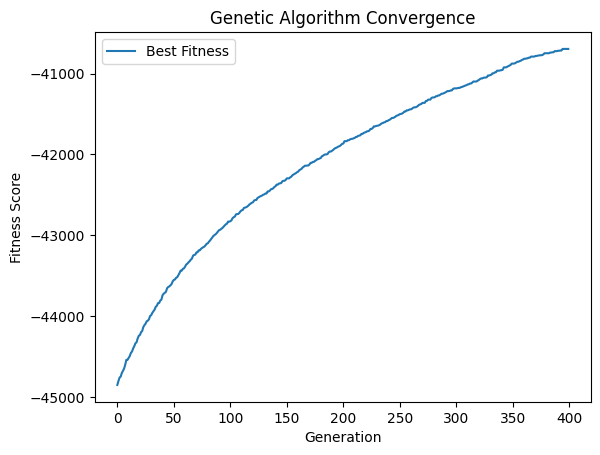

Optimized Weights: [   2.   -1.    0.    0.    1.    0.    3.   -2.   29.   -2.   20.   14.
   50.   -1.   22.   69.    0.   -1.    2.    0.   -1.    0.  -25.    0.
   -3.    1.    1.  -22.    0.   11.    5.   56.   -2.  -12.   36.    1.
   -5.   29.   39.    1.   38.  -22.   31.   -1.    2.   10.   18.   -3.
   15.    1.  -30.   -1.    0.  -71.  -49.   -2.    0.    3.   -2.    1.
   -1.   -1.    0.   -3.    0.    0.   -1.   -4.   -2.   -1.    3.    0.
   67.    0.   27.    8.  221.   61.   38.   87.    0.    0.   18.  -15.
   10.   74.    0.    2.  -74.   -1.    0.  -14.   36.   -8.   45.   69.
    1.  -14.   -1.    0.    0.  -32.    2.  -28.   46.   -1.  -36.    2.
    0.   -4.  -50.  -54.  -37.  -72.   -1.    0.    0.  -29.  -41.  -45.
    0.    1.    0.    0.   -1.    1.    3.    0.   -6.   -1.  -42.    4.
   29.   -3.    3.  -43.   -1.  -14.    7.   -1.  -12.    0.   62.  -20.
    0.   44.   -8.    1.   -2.    3.   -1.    8.  -44.    1.    0.    0.
   -1.    0.    0.   -3.    1.  

In [ ]:
best_weights, best_fitness_history = genetic_algorithm(fitness_function, population_size=200, generations=1000, elite_size=25, convergence_threshold=5)

# Plot Convergence Graph
plt.plot(best_fitness_history, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Genetic Algorithm Convergence")
plt.legend()
plt.show()

print("Optimized Weights:", best_weights)

PieceSquareTable.update(best_weights)
PieceSquareTable.save_to_json(PieceSquareTable.path)
Evaluation.update(best_weights)
Evaluation.save_to_json(Evaluation.path)
#cai chromosomes nay de lam j
chromosomes = [
                1.0, 0.8, -1.2, 0.7, 1.15,
                100, 300, 320, 500, 900, 10000,
                10, 10,
                20,
                5,
                10
            ]
print("Suggested weights fitness:", fitness_function(best_weights))